In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.14/09


In [3]:
infile_r = None  # input file handle

#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc0.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc1.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc2.0.root'
infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc3.0.root'

#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc0.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc1.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc2.0.root'
infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc3.0.root'

#infile = '../test7/ntuple_SingleMuon_Endcap_200k.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIIFall17D_csc0.0.root'

def define_collections(tree):
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return

def load_pgun():
  print('[INFO] Opening file: %s' % infile)
  global infile_r
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

def load_pgun_PU200():
  print('[INFO] Opening file: %s' % infile_PU200)
  global infile_r
  infile_r = root_open(infile_PU200)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

In [4]:
from six.moves import range, zip, map, filter

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    emtf_layer = self.lut[index]
    return emtf_layer

find_emtf_layer = EMTFLayer()

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  return check_bx(hit) and check_phi(hit)

In [5]:
# Main analysis

def analysis(pileup=0):
  # Load tree
  if pileup == 200:
    tree = load_pgun_PU200()
  else:
    tree = load_pgun()
  
  # Event range
  maxEvents = 100000
  #maxEvents = 10000
  
  # Output
  out_part, out_hits = [], []
  
  # __________________________________________________________________________
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Skip low pT muons
    if part.pt < 20:
      continue
    
    # Use positive endcap only
    f = lambda hit: hit.endcap == 1
    selected_hits = filter(f, evt.hits)
    
    # Use sim_tp == 1 only
    f = lambda hit: ((hit.type == kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1) and (hit.sim_tp1 == hit.sim_tp2)) or \
                    ((hit.type != kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1)) or \
                    ((hit.type == kME0) and False)
    selected_hits = filter(f, selected_hits)
    
    x_mask_array = np.ones((nlayers,), dtype=np.int32)
    for ihit, hit in enumerate(selected_hits):
      lay = find_emtf_layer(hit)
      if is_emtf_legit_hit(hit):
        x_mask_array[lay] = 0.0
    
    # Output
    out_part.append(part.eta)
    out_hits.append(x_mask_array)
    continue  # end loop over events

  print("DONE")
  return np.asarray(out_part), np.asarray(out_hits)

In [6]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc3.0.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
DONE
CPU times: user 1min 3s, sys: 12.7 s, total: 1min 15s
Wall time: 1min 15s


In [7]:
print out_part.shape, out_hits.shape, out_part.dtype, out_hits.dtype

(62378,) (62378, 16) float64 int32


In [8]:
%%time

# Run analysis
out_part_PU200, out_hits_PU200 = analysis(pileup=200)

[INFO] Opening file: ../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc3.0.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
DONE
CPU times: user 5min 4s, sys: 1min 5s, total: 6min 9s
Wall time: 5min 45s


In [9]:
print out_part_PU200.shape, out_hits_PU200.shape, out_part_PU200.dtype, out_hits_PU200.dtype

(81505,) (81505, 16) float64 int32


In [10]:
# Styling
plt.style.use('tdrstyle.mplstyle')

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
DEBUG:matplotlib.font_manager] findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=9.163 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


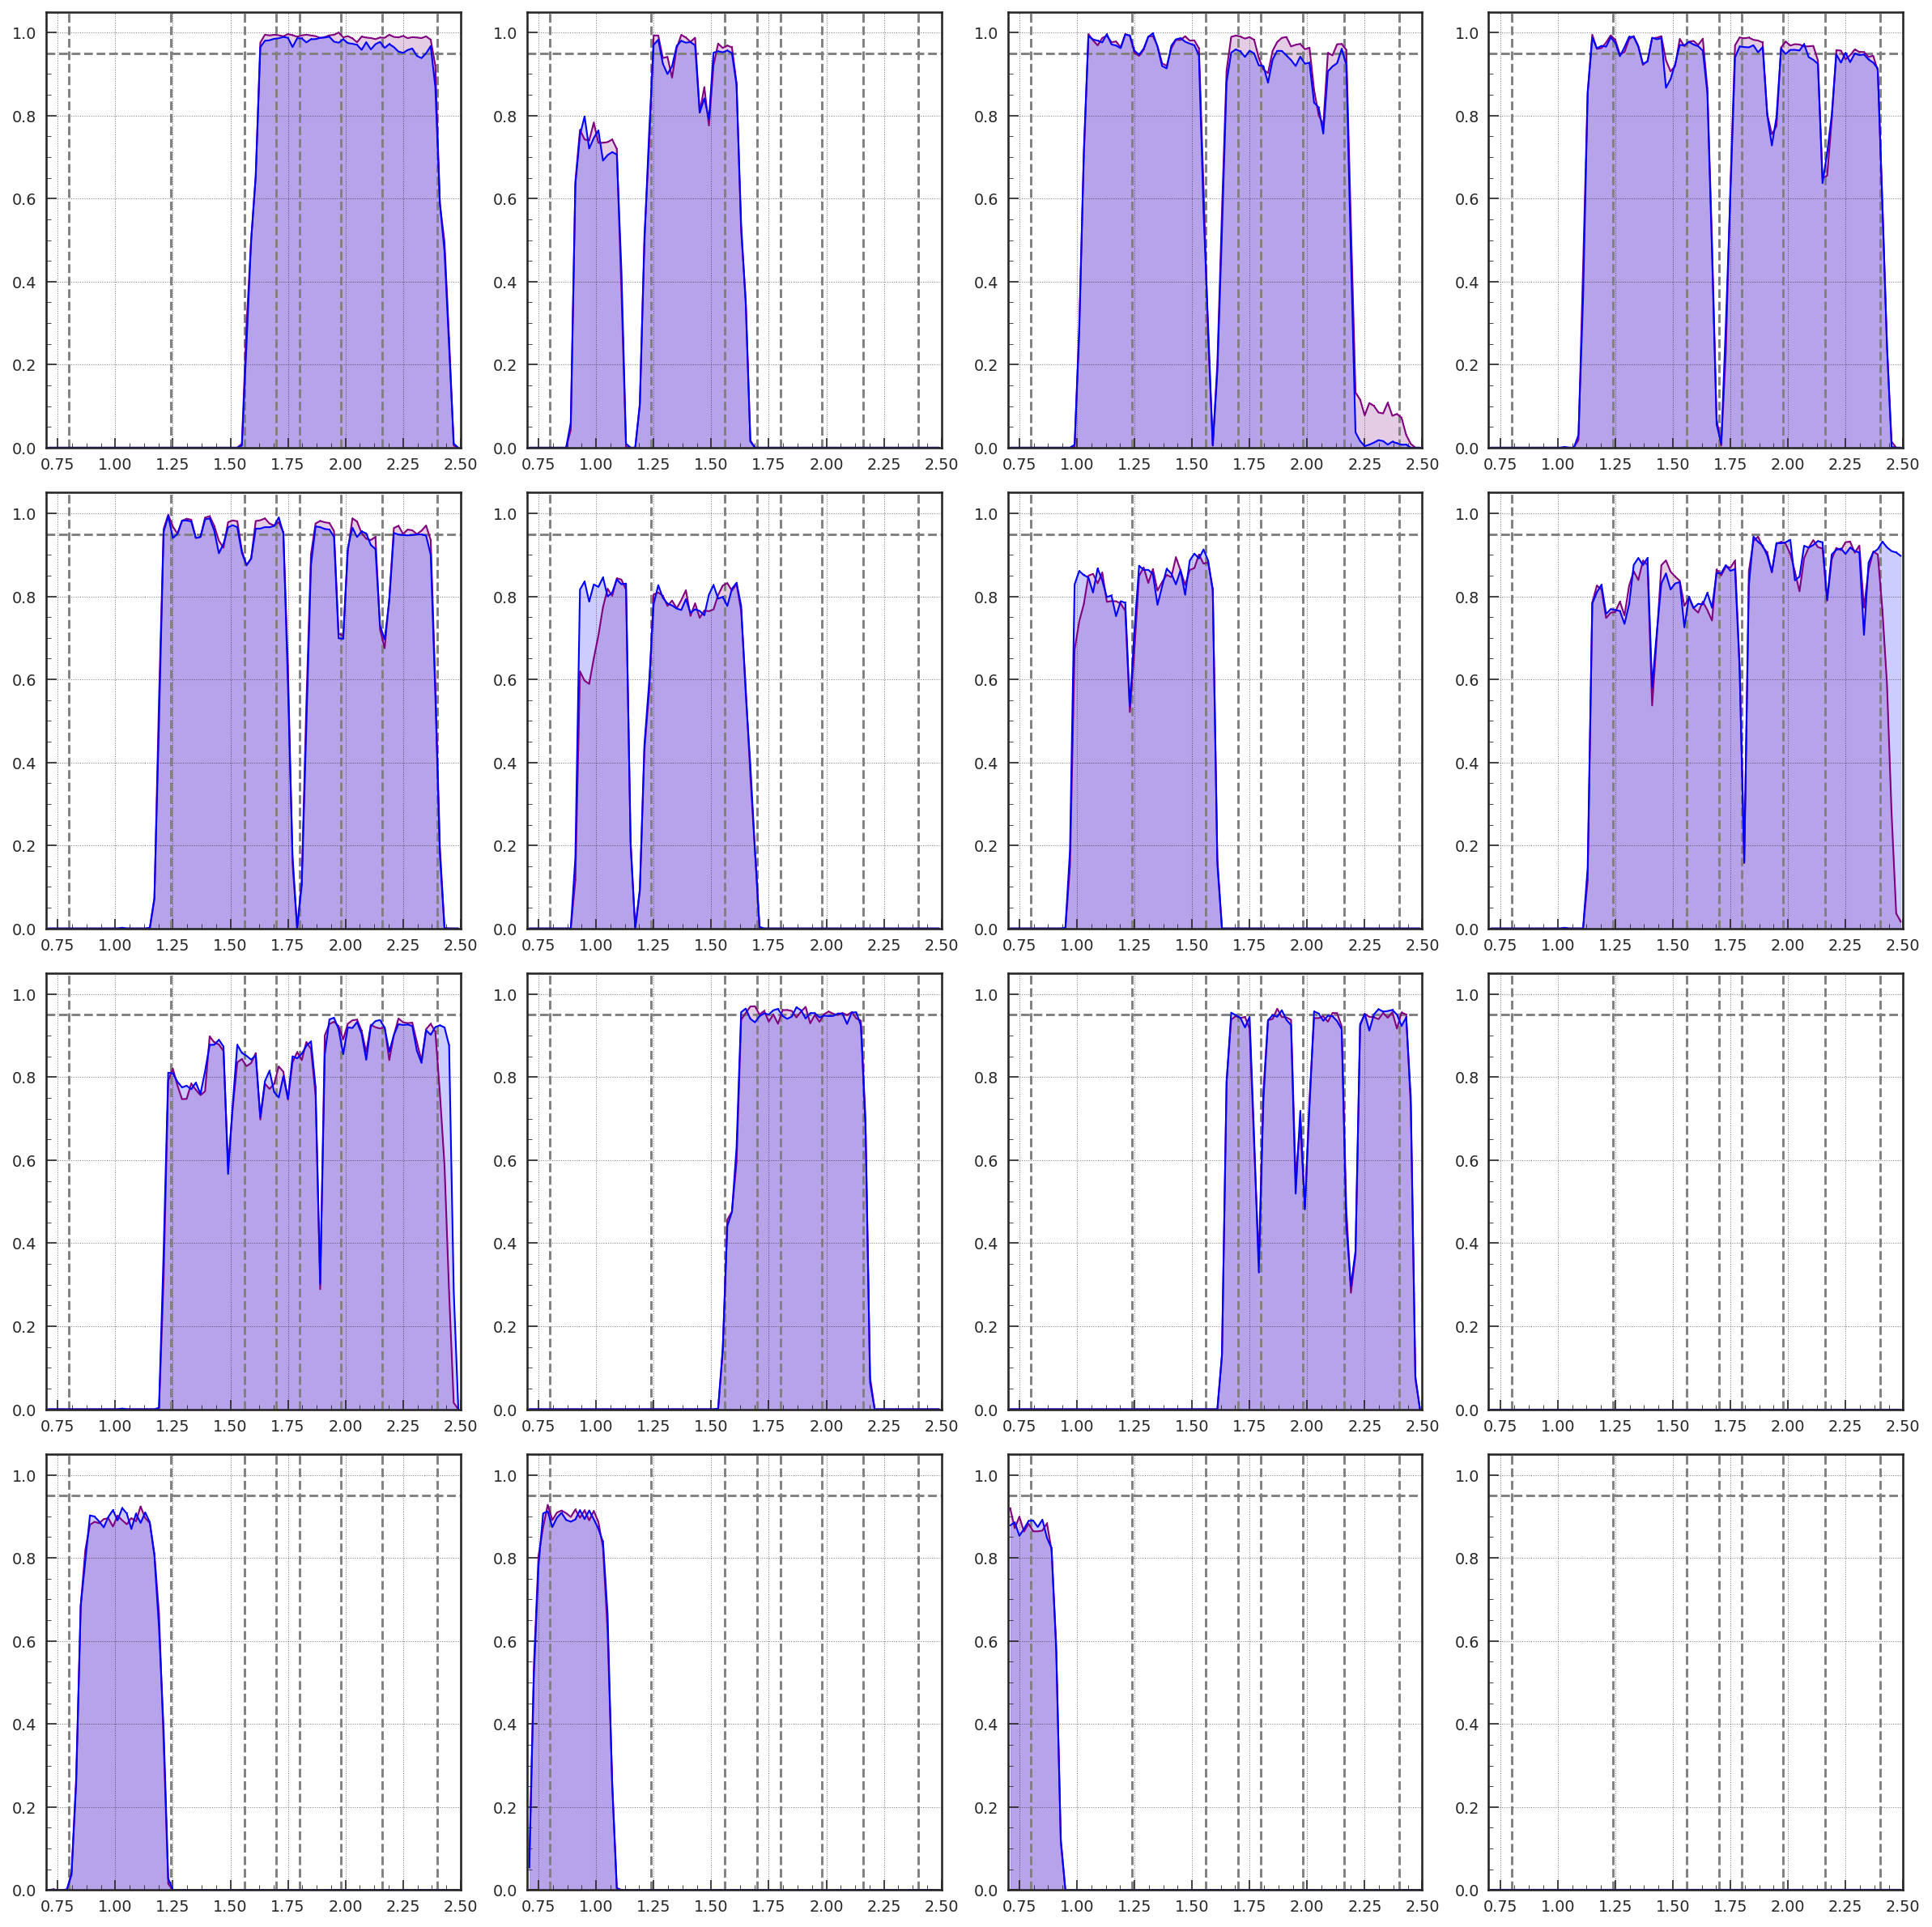

In [11]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

y_eta = out_part.copy()
x_mask = out_hits.copy().astype(np.bool)

y_eta_PU200 = out_part_PU200.copy()
x_mask_PU200 = out_hits_PU200.copy().astype(np.bool)

for i in xrange(nlayers):
  xmin, xmax = 0.7, 2.5
  ymin, ymax = 0, 1.05
  nbinsx = 90

  mask = x_mask[...,i]
  valid = ~mask  # valid hits

  denom_hist, edges = np.histogram(np.abs(y_eta), bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=nbinsx, range=(xmin,xmax))
  eff_hist = np.true_divide(num_hist, denom_hist)

  mask_PU200 = x_mask_PU200[...,i]
  valid_PU200 = ~mask_PU200

  denom_hist_PU200, edges = np.histogram(np.abs(y_eta_PU200), bins=nbinsx, range=(xmin,xmax))
  num_hist_PU200, edges = np.histogram(np.abs(y_eta_PU200)[valid_PU200], bins=nbinsx, range=(xmin,xmax))
  eff_hist_PU200 = np.true_divide(num_hist_PU200, denom_hist_PU200)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist

  ax = axs[i/4,i%4]
  ax.errorbar(xdata, ydata, color='purple', marker=',', capsize=0, lw=1)
  ax.fill_between(xdata, 0, ydata, color='purple', alpha=0.2)

  ydata = eff_hist_PU200
  ax.errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
  ax.fill_between(xdata, 0, ydata, color='b', alpha=0.2)
  
  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
    ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

plt.show()